### Consider:
* Rewrite cell 14
* Feature engineering (see results of tree fitting)
* SHAP
* Create a branch with polars. Compare compute performance

In [35]:
from kagglehub import dataset_load, KaggleDatasetAdapter

import numpy as np
import pandas as pd
import seaborn as sns
import statistics as st
import matplotlib.pyplot as plt

from sklearn.preprocessing import TargetEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import HistGradientBoostingClassifier

import shap

In [2]:
transactions = dataset_load(
    KaggleDatasetAdapter.PANDAS,
    'ealtman2019/credit-card-transactions',
    'credit_card_transactions-ibm_v2.csv',
)

In [3]:
def format_col_names(df: pd.DataFrame) -> pd.DataFrame:
    # Format column names: lowercase all characters and remove non-alphabetics
    names = {}
    for col in df.columns:
        names[col] = ''.join(char.lower() for char in col if char.isalpha())
    return df.rename(columns = names)


def clean_data(df: pd.DataFrame) -> pd.DataFrame:

    # Parse hour and minute data from time column
    df['hour'] = df['time'].str[0:2].astype('int64')
    df['minute'] = df['time'].str[3:5].astype('int64')

    # Convert amount to float
    df['amount'] = df['amount'].str.replace('$', '').astype('float')

    # Log transform amount to produce a less skewed distribution
    df['logamount'] = np.log(df['amount'])
    df['logamount'] = df['logamount'].fillna(0)
    df.loc[df['logamount'] == -np.inf, ['logamount']] = 0

    # Convert isfraud to binary
    df['isfraud'] = df['isfraud'].apply(lambda x: 1 if x == 'Yes' else 0)

    return df


def one_hot_encode_categoricals(df: pd.DataFrame) -> pd.DataFrame:
    # One-hot encode usechip, errors
    dummies_usechip = df['usechip'].str.get_dummies()
    dummies_errors = df['errors'].str.get_dummies(sep = ',')
    drop_cols = ['usechip', 'errors']
    return pd.concat([df.drop(columns = drop_cols), dummies_usechip, dummies_errors], axis = 'columns')


def balance_data(df: pd.DataFrame) -> pd.DataFrame:
    # Sample the data, producing a dataset balanced on isfraud
    num_fraud = df.loc[df['isfraud'] == 1].shape[0]
    fraudulent = df.loc[df['isfraud'] == 1].sample(num_fraud)
    not_fraudulent = df.loc[df['isfraud'] == 0].sample(num_fraud)
    return pd.concat([fraudulent, not_fraudulent])


def process_balance(df: pd.DataFrame) -> pd.DataFrame:
    df = format_col_names(df)
    df = clean_data(df)
    df = df.drop(columns = ['user', 'card', 'time', 'amount'])
    df = one_hot_encode_categoricals(df)
    df = format_col_names(df)
    df = balance_data(df)
    return df.sample(frac = 1) # Shuffle data

In [50]:
def target_encoding(df: pd.DataFrame, target: str) -> tuple[pd.DataFrame, pd.Series]:
    # Target encoding for merchantcity, merchantstate, merchantname, zip, mcc
    # To avoid data leakage, perform this function last (after balancing)
    drop_cols = ['merchantname', 'merchantcity', 'merchantstate', 'zip', 'mcc']
    for col in drop_cols:
        target_encoded = TargetEncoder().fit_transform(df[col].to_numpy().reshape(-1, 1), df[target].to_numpy())
        df = pd.concat([
            df.drop(columns = col),
            pd.DataFrame(target_encoded, columns = ['target_encoded_' + f'{col}'], index = df.index)
            ], axis = 'columns'
        )
    return (df.drop(columns = target), df[target])


def cv_fit_model(model, df: pd.DataFrame, target: str, n_splits: int) -> tuple[list, list]:
    # Fit model with cross-validation
    models, scores = [], []
    kf = KFold(n_splits = n_splits)
    # Perform target encoding independently on each split to avoid data leakage
    for train_ind, test_ind in kf.split(df):
        X_train, y_train = target_encoding(df.iloc[train_ind], target)
        X_test, y_test = target_encoding(df.iloc[test_ind], target)
        model.fit(X_train, y_train)
        models.append(model)
        score = model.score(X_test, y_test)
        scores.append(score)
    return (models, scores)


def median_model(model_scores: tuple[list, list]):
    # Return model with median performance
    median_score = st.median(model_scores[1])
    median_ind = model_scores[1].index(median_score)
    return model_scores[0][median_ind]


def gen_confusion_matrix(model_scores: tuple[list, list], df: pd.DataFrame, target: str):
    # Generate a confusion matrix
    model = median_model(model_scores)
    X, y = target_encoding(df, target)
    return ConfusionMatrixDisplay.from_estimator(model, X, y, normalize = 'true', cmap = 'Blues')


def gen_roc_curve(model_scores: tuple[list, list], df: pd.DataFrame, target: str):
    # Generate a ROC curve
    model = median_model(model_scores)
    X, y = target_encoding(df, target)
    return RocCurveDisplay.from_estimator(model, X, y)

In [47]:
transactions_processed_balanced = process_balance(transactions)

/Users/jon/.pyenv/versions/3.12.7/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/jon/.pyenv/versions/3.12.7/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [51]:
# Logistic regression model
logistic_model_scores = cv_fit_model(
    LogisticRegression(solver = 'newton-cholesky'),
    transactions_processed_balanced,
    target = 'isfraud',
    n_splits = 5
)

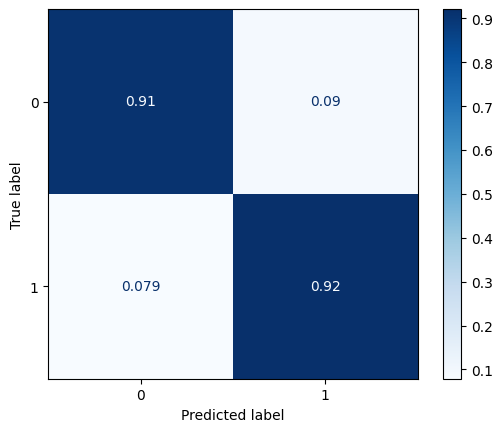

In [26]:
gen_confusion_matrix(logistic_model_scores, transactions_processed_balanced, target = 'isfraud')

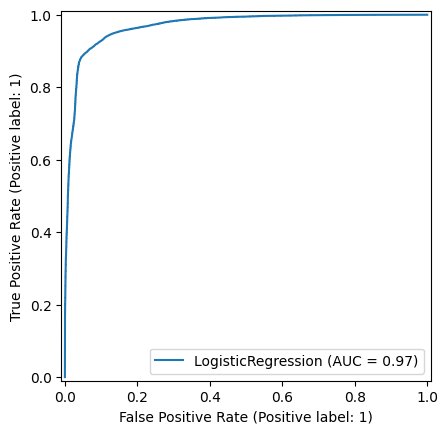

In [22]:
gen_roc_curve(logistic_model_scores, transactions_processed_balanced, target = 'isfraud')

In [61]:
# Decision tree model
tree_model_scores = cv_fit_model(
    DecisionTreeClassifier(ccp_alpha = 0.005),
    transactions_processed_balanced,
    target = 'isfraud',
    n_splits = 5
)

[Text(0.5, 0.9, 'x[19] <= 0.653\ngini = 0.5\nsamples = 47612\nvalue = [23853.0, 23759.0]'),
 Text(0.2, 0.7, 'x[20] <= 0.545\ngini = 0.194\nsamples = 23198\nvalue = [20666, 2532]'),
 Text(0.35, 0.8, 'True  '),
 Text(0.1, 0.5, 'gini = 0.088\nsamples = 17815\nvalue = [16990, 825]'),
 Text(0.3, 0.5, 'x[19] <= 0.29\ngini = 0.433\nsamples = 5383\nvalue = [3676.0, 1707.0]'),
 Text(0.2, 0.3, 'gini = 0.294\nsamples = 3226\nvalue = [2648, 578]'),
 Text(0.4, 0.3, 'x[16] <= 0.514\ngini = 0.499\nsamples = 2157\nvalue = [1028, 1129]'),
 Text(0.3, 0.1, 'gini = 0.252\nsamples = 758\nvalue = [112, 646]'),
 Text(0.5, 0.1, 'gini = 0.452\nsamples = 1399\nvalue = [916.0, 483.0]'),
 Text(0.8, 0.7, 'x[16] <= 0.336\ngini = 0.227\nsamples = 24414\nvalue = [3187, 21227]'),
 Text(0.65, 0.8, '  False'),
 Text(0.7, 0.5, 'x[17] <= 0.866\ngini = 0.444\nsamples = 3588\nvalue = [2396, 1192]'),
 Text(0.6, 0.3, 'gini = 0.337\nsamples = 2988\nvalue = [2348, 640]'),
 Text(0.8, 0.3, 'gini = 0.147\nsamples = 600\nvalue = [4

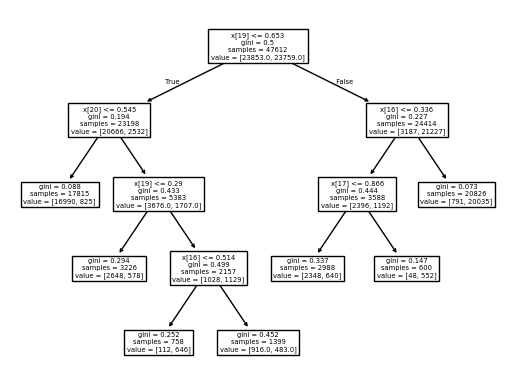

In [ ]:
# Most significant splits:
# x[19]: target_encoded_merchantstate
# x[16]: technicalglitch
# x[20]: target_encoded_zip
# x[17]: target_encoded_merchantname
plot_tree(median_model(tree_model_scores))

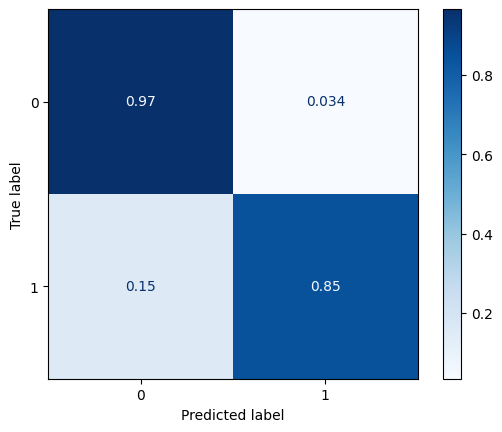

In [56]:
gen_confusion_matrix(tree_model_scores, transactions_processed_balanced, target = 'isfraud')

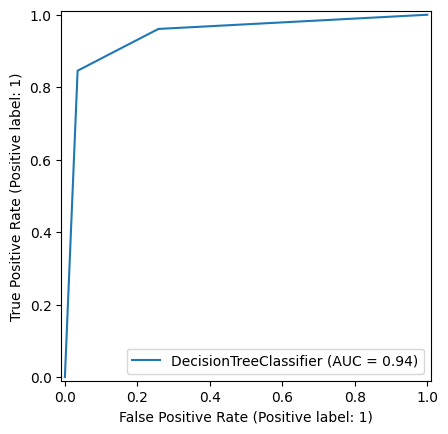

In [57]:
gen_roc_curve(tree_model_scores, transactions_processed_balanced, target = 'isfraud')

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

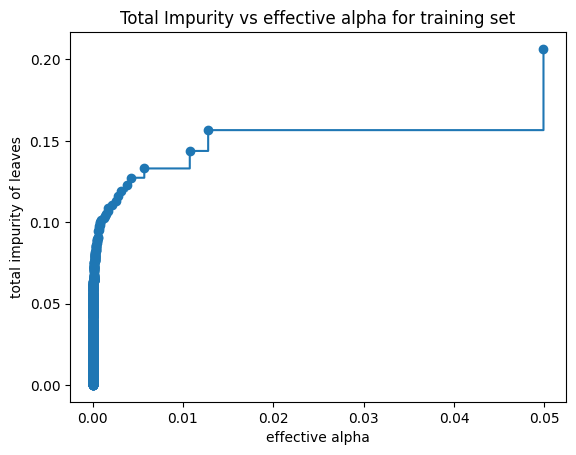

In [ ]:
# Means of determining appropriate alpha_ccp values:
# https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html#sphx-glr-auto-examples-tree-plot-cost-complexity-pruning-py
'''
target_encoded = target_encoding(transactions_processed_balanced, 'isfraud')
path = median_model(tree_model_scores).cost_complexity_pruning_path(*target_encoded)

ccp_alphas, impurities = path.ccp_alphas, path.impurities
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")
'''

In [ ]:
# Histogram gradient boosting tree model
hgb_model_scores = cv_fit_model(
    HistGradientBoostingClassifier(validation_fraction = None),
    transactions_processed_balanced,
    target = 'isfraud',
    n_splits = 5
)

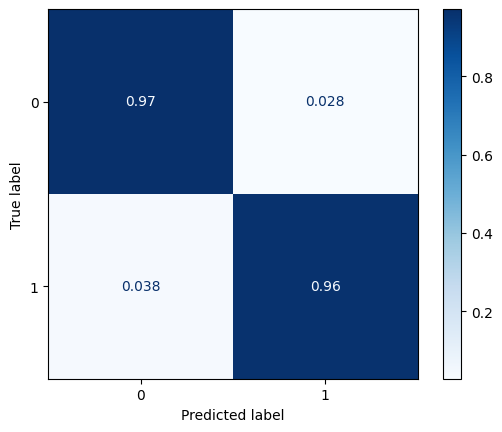

In [10]:
gen_confusion_matrix(hgb_model_scores, transactions_processed_balanced, target = 'isfraud')

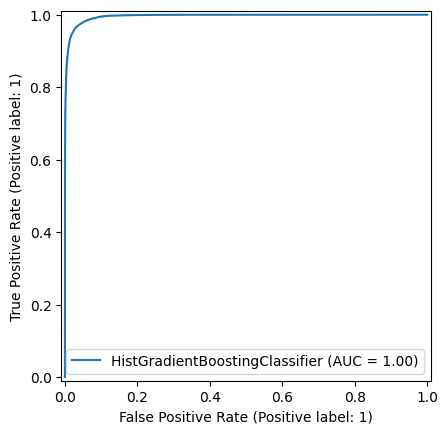

In [11]:
gen_roc_curve(hgb_model_scores, transactions_processed_balanced, target = 'isfraud')

In [27]:
hgb_model = median_model(hgb_model_scores)
explainer = shap.TreeExplainer(hgb_model)